# Flappy Bird

## PART 1:
Produce a Table of RL-based approaches (Policy Iteration, Value Iteration, Q Learning, TD, Monte Carlo) where each row is an approach and each column is a dimension that differentiates the approaches such as model free, which of the quintuple each uses (State, Action, Transitions, Rewards, etc..), and other dimensions

## Part 2:
Flappybird is a side-scrolling game where the agent must successfully navigate through gaps between pipes. The up arrow causes the bird to accelerate upwards. If the bird makes contact with the ground or pipes, or goes above the top of the screen, the game is over. For each pipe it passes through it gains a positive reward. Each time a terminal state is reached it receives a negative reward.

Determine a good policy for Flappy Birds using  any one or more of the following algorithms (aim to get 140 points or more!):
* Policy Iteration, Value Iteration, Q Learning, TD, Monte Carlo

You may have to discretize the  space of  following parameters.
* Vertical distance from lower pipe
* Horizontal distance from next pair of pipes
* Life: Dead or Living
## Actions
For each state, there two possible actions
* Click
* Do Nothing
## Rewards
The reward structure is purely based on the "Life" parameter. One possible such structure could be the following (feel free to explore more):
* +1 if Flappy Bird is still alive
* -1000 if Flappy Bird is dead

## Flappy Birds Simulator:
Please use the openai gym environment for this project:

* https://gym.openai.com/envs/FlappyBird-v0/


## Submission

Part of your your report should be a video of how your agent learns showing progress after: after 10 minutes of  training; after 30 minutes; after 5 hours etc.; 
In addition please submit a notebook (with documented code) and a discussion section. 

# Deadline 
This Homework is due on Thursday July 5 at 9AM.

## Declartions

In [66]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [51]:
import datetime
import numpy as np
import pandas as pd
import itertools
import sys
import os
import string
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

from matplotlib.cbook import MatplotlibDeprecationWarning
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from pylab import rc
import json
import random
#from itertools import izip
import seaborn as sns
sns.reset_orig()

import warnings
warnings.filterwarnings('ignore')   


## Agent Classes

### Agent base class

In [44]:
class Agent(object):
    """
    The Agent class with utility methods   
    """
    def __init__(self,                
                 epsilon=.2, epsilon_decay=True, epsilon_decay_param=.01, 
                 tau=100, tau_decay=True, tau_decay_param=.01, 
                 policy_strategy='e-greedy'):
        
        """Initialize agent parameters.
        :param epsilon: Float value (0, 1) prob of taking random action vs. taking greedy action.
        :param epsilon_decay: Bool indicating whether to use decay of epsilon over episodes.
        :param epsilon_decay_param: Float param for decay given by epsilon*e^(-epsilon_decay_param * episode)
        :param tau: Float value for temp. param in the softmax, tau -> 0 = greedy, tau -> infinity = random.
        :param tau_decay: Bool indicating whether to use decay of tau over episodes.
        :param tau_decay_param: Float param for decay given by tau*e^(-tau_decay_param * episode)
        :param policy_strategy: String in {softmax, e-greedy, random}, exploration vs exploitation strategy.  
        """              
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_param = epsilon_decay_param
        self.tau = tau
        self.tau_decay = tau_decay
        self.tau_decay_param = tau_decay_param
        self.policy_strategy = policy_strategy  
        
        self.moves = []
            
    #end def __init__  
    
    def choose_action(self, s):
        """Choose action for a TD algorithm that is updating using q values.

        The policy strategy for choosing an action is either chosen using a
        softmax strategy, epsilon greedy strategy, greedy strategy, or a random strategy.

        :param s: Integer index of the current state index the agent is in.

        :return a: Integer index of the chosen index for the action to take.
        """

        if self.policy_strategy == 'softmax':
            a = self.softmax(s)
        elif self.policy_strategy == 'e-greedy':
            a = self.epsilon_greedy(s)
        elif self.policy_strategy == 'greedy':
            a = self.random_policy(self.qvalues[s])
        else:
            a = np.random.choice(self.actions)

        return a
    
    def random_policy(self, list):
        
        """Helper function to get the argmax of an array breaking ties randomly.
        
        :param arr: 1D or 1D numpy array to find the argmax for.
    
        :return choice or argmax_array: Choice is integer index of array with 
        the max value, argmax_array is array of integer index of max value in each 
        row of the original array.
        """
    
        arr = np.array(list)
        
        if len(arr.shape) == 1:
            choice = np.random.choice(np.flatnonzero(arr == arr.max()))
            return choice
        else:
            N = arr.shape[0]
            argmax_array = np.zeros(N)
    
            for i in range(N):
                choice = np.random.choice(np.flatnonzero(arr[i] == arr[i].max()))
                argmax_array[i] = choice
    
        argmax_array = argmax_array.astype(int)
    
        return argmax_array
    
    #end def random_policy
    
    def epsilon_greedy(self, s):
        """Epsilon greedy exploration-exploitation strategy.

        This policy strategy selects the current best action with probability
        of 1 - epsilon, and a random action with probability epsilon.
        
        :param s: Integer index of the current state index the agent is in.

        :return a: Integer index of the chosen index for the agent to take.
        """

        if self.epsilon_decay:
            epsilon = self.epsilon * np.exp(-self.epsilon_decay_param * len(self.moves))
        else:
            epsilon = self.epsilon      
            
        if not np.random.binomial(1, epsilon):
            a = self.random_policy(self.qvalues[s])
        else:
            a = np.random.choice(self.actions)

        return a
    #end def epsilon_greedy
    
    def softmax(self, s):
        """Softmax exploration-exploitation strategy.

        This policy strategy uses a boltzman distribution with a temperature 
        parameter tau, to assign the probabilities of choosing an action based
        off of the current q value of the state and action.

        :param s: Integer index of the current state index the agent is in.

        :return a: Integer index of the chosen index for the agent to take.
        """

        if self.tau_decay:
            # Capping the minimum value of tau to prevent overflow issues.
            tau = max(self.tau * np.exp(-self.tau_decay_param * self.episode), .1)
        else:
            tau = self.tau

        if len(self.tau_choices) <= self.episode:
            self.tau_choices.append(tau)

        exp = lambda s, a: np.exp(self.qvalues[s, a]/tau)
        values = []
        probs = []

        for a in self.actions:
            # Catching overflow and returning random action if it occurs.
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    value = exp(s, a)
                except RuntimeWarning:
                    return self.random_policy(self.qvalues[s])

            values.append(value) 
        
        total = sum(values)
        probs = [val/total for val in values]

        try:
            sample = np.random.multinomial(1, probs).tolist()
            a = sample.index(1)
        except:
            # Return random action if there is a overflow issue.
            a = self.random_policy(self.qvalues[s])

        return a


### Flappy Bird Agent class

In [45]:
class FlappyBirdAgent(Agent):
    """
    The Agent class that applies the Qlearning logic to Flappy bird game
    After every iteration (iteration = 1 game that ends with the bird dying) updates Q values
    After every SAVE_N iterations, saves the Q values to the local JSON file
    """
    def __init__(self,                
                 epsilon=.2, epsilon_decay=True, epsilon_decay_param=.01, 
                 tau=100, tau_decay=True, tau_decay_param=.01, 
                 policy_strategy='e-greedy'):
        
        """Initialize agent parameters.
        :param epsilon: Float value (0, 1) prob of taking random action vs. taking greedy action.
        :param epsilon_decay: Bool indicating whether to use decay of epsilon over episodes.
        :param epsilon_decay_param: Float param for decay given by epsilon*e^(-epsilon_decay_param * episode)
        :param tau: Float value for temp. param in the softmax, tau -> 0 = greedy, tau -> infinity = random.
        :param tau_decay: Bool indicating whether to use decay of tau over episodes.
        :param tau_decay_param: Float param for decay given by tau*e^(-tau_decay_param * episode)
        :param policy_strategy: String in {softmax, e-greedy, random}, exploration vs exploitation strategy.  
        """       
        
        super(FlappyBirdAgent, self).__init__(epsilon, epsilon_decay, epsilon_decay_param, 
                                                tau, tau_decay, tau_decay_param, 
                                                policy_strategy)
        
        self.gameCNT = 0 # Game count of current run, incremented after every death
        self.SAVE_N = 25 # Number of iterations to dump Q values to JSON after  
        
        self.load_qvalues()
        
    #end def __init__

    def load_qvalues(self):
        """
        Load q values from a JSON file
        """
        self.qvalues = {}
        try:
            fil = open('qvalues.json', 'r')
        except IOError:
            return
        self.qvalues = json.load(fil)
        fil.close()
    #end def load_qvalues
    
    def map_state(self, xdif, ydif, vel):
        """
        Map the (xdif, ydif, vel) to the respective state, with regards to the grids
        The state is a string, "xdif_ydif_vel"

        X -> [-40,-30...120] U [140, 210 ... 420]
        Y -> [-300, -290 ... 160] U [180, 240 ... 420]
        """
        if xdif < 140:
            xdif = int(xdif) - (int(xdif) % 10)
        else:
            xdif = int(xdif) - (int(xdif) % 70)

        if ydif < 180:
            ydif = int(ydif) - (int(ydif) % 10)
        else:
            ydif = int(ydif) - (int(ydif) % 60)

        return str(int(xdif))+'_'+str(int(ydif))+'_'+str(vel)
    #end def map_state
    
    def act(self, xdif, ydif, vel):
        """
        Chooses the best action with respect to the current state - Chooses 0 (don't flap) to tie-break
        """
        state = self.map_state(xdif, ydif, vel)

        self.moves.append( [self.last_state, self.last_action, state] ) # Add the experience to the history

        self.last_state = state # Update the last_state with the current state
                
        self.last_action = self.choose_action(state)
        
        return self.last_action   
       
    #end def act
    
    def actOld(self, xdif, ydif, vel):
        """
        Chooses the best action with respect to the current state - Chooses 0 (don't flap) to tie-break
        """
        state = self.map_state(xdif, ydif, vel)

        self.moves.append( [self.last_state, self.last_action, state] ) # Add the experience to the history

        self.last_state = state # Update the last_state with the current state

        if self.qvalues[state][0] >= self.qvalues[state][1]:
            self.last_action = 0
            return 0
        else:
            self.last_action = 1
            return 1
    
    def get_last_state(self):
        return self.last_state
    #end def get_last_state
   

    def save_qvalues(self):
        """
        Save the qvalues to the JSON file
        """
        if self.gameCNT % self.SAVE_N == 0:
            fil = open('qvalues.json', 'w')
            json.dump(self.qvalues, fil)
            fil.close()
            print('Q-values updated on local file.')
        #end if
    #end def save_qvalues

### Flappy Bird Agent Q-Learning class

In [46]:
class FlappyBirdAgentQLearning(FlappyBirdAgent):
    """
    The Model Free Agent class that applies the Model Free algorithms to Flappy bird game
    After every iteration (iteration = 1 game that ends with the bird dying) updates Q values
    After every SAVE_N iterations, saves the Q values to the local JSON file
    """
    def __init__(self,
                 learning_rate = 0.7,
                 discount_factor = 1.0,
                 epsilon=.2, epsilon_decay=True, epsilon_decay_param=.01, 
                 tau=100, tau_decay=True, tau_decay_param=.01, 
                 policy_strategy='e-greedy'):
        
        """Initialize agent parameters.
        :param epsilon: Float value (0, 1) prob of taking random action vs. taking greedy action.
        :param epsilon_decay: Bool indicating whether to use decay of epsilon over episodes.
        :param epsilon_decay_param: Float param for decay given by epsilon*e^(-epsilon_decay_param * episode)
        :param tau: Float value for temp. param in the softmax, tau -> 0 = greedy, tau -> infinity = random.
        :param tau_decay: Bool indicating whether to use decay of tau over episodes.
        :param tau_decay_param: Float param for decay given by tau*e^(-tau_decay_param * episode)
        :param policy_strategy: String in {softmax, e-greedy, random}, exploration vs exploitation strategy.  
        """       
        super(FlappyBirdAgentQLearning, self).__init__(epsilon, epsilon_decay, epsilon_decay_param, 
                                                tau, tau_decay, tau_decay_param, 
                                                policy_strategy)
                
        self.discount = discount_factor
        self.r = {0: 1, 1: -1000} # Reward function
        self.lr = learning_rate        
        self.last_state = "420_240_0"
        self.last_action = 0
       
        self.actions = [0,1] # 0=down 1=up
                
    #end def __init__
    
    def learn(self):
        """
        Update qvalues via iterating over experiences
        """
        history = list(reversed(self.moves))

        # Flag if the bird died in the top pipe
        high_death_flag = True if int(history[0][2].split('_')[1]) > 120 else False

        # Q-learning score updates
        t = 1
        for exp in history:
            state = exp[0]
            act = exp[1]
            res_state = exp[2]

            # Select reward
            if t == 1 or t == 2:
                cur_reward = self.r[1]
            elif high_death_flag and act:
                cur_reward = self.r[1]
                high_death_flag = False
            else:
                cur_reward = self.r[0]

            # Update
            self.qvalues[state][act] = (1-self.lr) * (self.qvalues[state][act]) + \
                                        self.lr * ( cur_reward + self.discount * max(self.qvalues[res_state]) )
            t += 1
        #end for

        self.gameCNT += 1  # increase game count
        self.save_qvalues()  # save q values (if game count % SAVE_N == 0)
        self.moves = []  # clear history after updating strategies
        
        #lower exploration rate
        self.epsilon = max(0, self.epsilon - self.epsilon_decay_param)
    #end def learn

### Flappy Bird Agent SARSA class

In [47]:
class FlappyBirdAgentSARSA(FlappyBirdAgent):
    """
    The Model Free Agent class that applies the Model Free algorithms to Flappy bird game
    After every iteration (iteration = 1 game that ends with the bird dying) updates Q values
    After every SAVE_N iterations, saves the Q values to the local JSON file
    """
    def __init__(self,
                 learning_rate = 0.7,
                 discount_factor = 1.0,
                 epsilon=.2, epsilon_decay=True, epsilon_decay_param=.01, 
                 tau=100, tau_decay=True, tau_decay_param=.01, 
                 policy_strategy='e-greedy'):
        
        """Initialize agent parameters.
        :param epsilon: Float value (0, 1) prob of taking random action vs. taking greedy action.
        :param epsilon_decay: Bool indicating whether to use decay of epsilon over episodes.
        :param epsilon_decay_param: Float param for decay given by epsilon*e^(-epsilon_decay_param * episode)
        :param tau: Float value for temp. param in the softmax, tau -> 0 = greedy, tau -> infinity = random.
        :param tau_decay: Bool indicating whether to use decay of tau over episodes.
        :param tau_decay_param: Float param for decay given by tau*e^(-tau_decay_param * episode)
        :param policy_strategy: String in {softmax, e-greedy, random}, exploration vs exploitation strategy.  
        """       
        super(FlappyBirdAgentSARSA, self).__init__(epsilon, epsilon_decay, epsilon_decay_param, 
                                                tau, tau_decay, tau_decay_param, 
                                                policy_strategy)
                
        self.discount = discount_factor
        self.r = {0: 1, 1: -1000} # Reward function
        self.lr = learning_rate        
        self.last_state = "420_240_0"
        self.last_action = 0
       
        self.actions = [0,1] # 0=down 1=up
                
    #end def __init__
    
    def learn(self):
        """
        Update qvalues via iterating over experiences
        """
        history = list(reversed(self.moves))

        # Flag if the bird died in the top pipe
        high_death_flag = True if int(history[0][2].split('_')[1]) > 120 else False

        # Q-learning score updates
        t = 1
        for exp in history:
            state = exp[0]
            act = exp[1]
            res_state = exp[2]
            
            pos = 0

            # Select reward
            if t == 1 or t == 2:
                pos = 1
                cur_reward = self.r[pos]
                
            elif high_death_flag and act:
                pos = 1
                cur_reward = self.r[pos]
                high_death_flag = False
            else:
                pos = 0
                cur_reward = self.r[pos]

            # Update
            self.qvalues[state][act] = (1-self.lr) * (self.qvalues[state][act]) + \
                                        self.lr * ( cur_reward + self.discount * self.qvalues[res_state][pos])
            t += 1
        #end for

        self.gameCNT += 1  # increase game count
        self.save_qvalues()  # save q values (if game count % SAVE_N == 0)
        self.moves = []  # clear history after updating strategies
        
        #lower exploration rate
        self.epsilon = max(0, self.epsilon - self.epsilon_decay_param)
    #end def learn

### Flappy Bird Environment Class

In [64]:
from itertools import cycle
import random
import sys

import pygame
from pygame.locals import *

class FlappyBirdEnviornment(object):    
    
    def __init__(self, agent, play_sounds = False):  
        self.agent = agent
        
        self.FPS = 60
        self.SCREENWIDTH  = 288
        self.SCREENHEIGHT = 512
        self.play_sounds = play_sounds

        # amount by which base can maximum shift to left
        self.PIPEGAPSIZE  = 100 # gap between upper and lower part of pipe
        self.BASEY        = self.SCREENHEIGHT * 0.79
        # image, sound and hitmask  dicts
        self.IMAGES, self.SOUNDS, self.HITMASKS = {}, {}, {}

        # list of all possible players (tuple of 3 positions of flap)
        self.PLAYERS_LIST = (
            # red bird
            (
                'assets/sprites/redbird-upflap.png',
                'assets/sprites/redbird-midflap.png',
                'assets/sprites/redbird-downflap.png',
            ),
            # blue bird
            (
                # amount by which base can maximum shift to left
                'assets/sprites/bluebird-upflap.png',
                'assets/sprites/bluebird-midflap.png',
                'assets/sprites/bluebird-downflap.png',
            ),
            # yellow bird
            (
                'assets/sprites/yellowbird-upflap.png',
                'assets/sprites/yellowbird-midflap.png',
                'assets/sprites/yellowbird-downflap.png',
            ),
        )

        # list of backgrounds
        self.BACKGROUNDS_LIST = (
            'assets/sprites/background-day.png',
            'assets/sprites/background-night.png',
        )

        # list of pipes
        self.PIPES_LIST = (
            'assets/sprites/pipe-green.png',
            'assets/sprites/pipe-red.png',
        )

        self.episode = 0
        self.history = pd.DataFrame(columns=["Episode", "Score"])
        self.start = datetime.datetime.now()
        
    #end def __int__

    def simulate(self, max_score):
        
        pygame.init()
        self.FPSCLOCK = pygame.time.Clock()
        self.SCREEN = pygame.display.set_mode((self.SCREENWIDTH, self.SCREENHEIGHT))
        pygame.display.set_caption('Flappy Bird')

        # numbers sprites for score display
        self.IMAGES['numbers'] = (
            pygame.image.load('assets/sprites/0.png').convert_alpha(),
            pygame.image.load('assets/sprites/1.png').convert_alpha(),
            pygame.image.load('assets/sprites/2.png').convert_alpha(),
            pygame.image.load('assets/sprites/3.png').convert_alpha(),
            pygame.image.load('assets/sprites/4.png').convert_alpha(),
            pygame.image.load('assets/sprites/5.png').convert_alpha(),
            pygame.image.load('assets/sprites/6.png').convert_alpha(),
            pygame.image.load('assets/sprites/7.png').convert_alpha(),
            pygame.image.load('assets/sprites/8.png').convert_alpha(),
            pygame.image.load('assets/sprites/9.png').convert_alpha()
        )

        # game over sprite
        self.IMAGES['gameover'] = pygame.image.load('assets/sprites/gameover.png').convert_alpha()
        # message sprite for welcome screen
        self.IMAGES['message'] = pygame.image.load('assets/sprites/message.png').convert_alpha()
        # base (ground) sprite
        self.IMAGES['base'] = pygame.image.load('assets/sprites/base.png').convert_alpha()

        # sounds
        if 'win' in sys.platform:
            soundExt = '.wav'
        else:
            soundExt = '.ogg'

        self.SOUNDS['die']    = pygame.mixer.Sound('assets/audio/die' + soundExt)
        self.SOUNDS['hit']    = pygame.mixer.Sound('assets/audio/hit' + soundExt)
        self.SOUNDS['point']  = pygame.mixer.Sound('assets/audio/point' + soundExt)
        self.SOUNDS['swoosh'] = pygame.mixer.Sound('assets/audio/swoosh' + soundExt)
        self.SOUNDS['wing']   = pygame.mixer.Sound('assets/audio/wing' + soundExt)

        while True:
            # select random background sprites
            randBg = random.randint(0, len(self.BACKGROUNDS_LIST) - 1)
            self.IMAGES['background'] = pygame.image.load(self.BACKGROUNDS_LIST[randBg]).convert()

            # select random player sprites
            randPlayer = random.randint(0, len(self.PLAYERS_LIST) - 1)
            self.IMAGES['player'] = (
                pygame.image.load(self.PLAYERS_LIST[randPlayer][0]).convert_alpha(),
                pygame.image.load(self.PLAYERS_LIST[randPlayer][1]).convert_alpha(),
                pygame.image.load(self.PLAYERS_LIST[randPlayer][2]).convert_alpha(),
            )

            # select random pipe sprites
            pipeindex = random.randint(0, len(self.PIPES_LIST) - 1)
            self.IMAGES['pipe'] = (
                pygame.transform.rotate(
                    pygame.image.load(self.PIPES_LIST[pipeindex]).convert_alpha(), 180),
                pygame.image.load(self.PIPES_LIST[pipeindex]).convert_alpha(),
            )

            # hismask for pipes
            self.HITMASKS['pipe'] = (
                self.getHitmask(self.IMAGES['pipe'][0]),
                self.getHitmask(self.IMAGES['pipe'][1]),
            )

            # hitmask for player
            self.HITMASKS['player'] = (
                self.getHitmask(self.IMAGES['player'][0]),
                self.getHitmask(self.IMAGES['player'][1]),
                self.getHitmask(self.IMAGES['player'][2]),
            )

            movementInfo = self.showWelcomeAnimation()
            crashInfo =  self.play(movementInfo, max_score)
            self.showGameOverScreen(crashInfo)


    def showWelcomeAnimation(self):
        """Shows welcome screen animation of flappy bird"""
        # index of player to blit on screen
        playerIndex = 0
        playerIndexGen = cycle([0, 1, 2, 1])
        # iterator used to change playerIndex after every 5th iteration
        loopIter = 0

        playerx = int(self.SCREENWIDTH * 0.2)
        playery = int((self.SCREENHEIGHT - self.IMAGES['player'][0].get_height()) / 2)

        messagex = int((self.SCREENWIDTH - self.IMAGES['message'].get_width()) / 2)
        messagey = int(self.SCREENHEIGHT * 0.12)

        basex = 0
        # amount by which base can maximum shift to left
        baseShift = self.IMAGES['base'].get_width() - self.IMAGES['background'].get_width()

        # player shm for up-down motion on welcome screen
        playerShmVals = {'val': 0, 'dir': 1}


        while True:
            ''' De-activated the press key functionality

            for event in pygame.event.get():
                if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                    pygame.quit()
                    sys.exit()
                if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
                    # make first flap sound and return values for mainGame
                    SOUNDS['wing'].play()
                    return {
                        'playery': playery + playerShmVals['val'],
                        'basex': basex,
                        'playerIndexGen': playerIndexGen,
                    }
            '''
            if self.play_sounds == True: self.SOUNDS['wing'].play()

            return {
                'playery': playery + playerShmVals['val'],
                'basex': basex,
                'playerIndexGen': playerIndexGen,
            }

            # adjust playery, playerIndex, basex
            if (loopIter + 1) % 5 == 0:
                playerIndex = next(playerIndexGen)

            loopIter = (loopIter + 1) % 30
            basex = -((-basex + 4) % baseShift)
            playerShm(playerShmVals)

            # draw sprites
            self.SCREEN.blit(self.IMAGES['background'], (0,0))
            self.SCREEN.blit(self.IMAGES['player'][playerIndex],
                        (playerx, playery + playerShmVals['val']))
            self.SCREEN.blit(self.IMAGES['message'], (messagex, messagey))
            self.SCREEN.blit(self.IMAGES['base'], (basex, self.BASEY))

            pygame.display.update()
            self.FPSCLOCK.tick(FPS)


    def play(self,movementInfo, max_iterations):

        score = playerIndex = loopIter = 0
        playerIndexGen = movementInfo['playerIndexGen']

        playerx, playery = int(self.SCREENWIDTH * 0.2), movementInfo['playery']

        basex = movementInfo['basex']
        baseShift = self.IMAGES['base'].get_width() - self.IMAGES['background'].get_width()

        # get 2 new pipes to add to upperPipes lowerPipes list
        newPipe1 = self.getRandomPipe()
        newPipe2 = self.getRandomPipe()

        # list of upper pipes
        upperPipes = [
            {'x': self.SCREENWIDTH + 200, 'y': newPipe1[0]['y']},
            {'x': self.SCREENWIDTH + 200 + (self.SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
        ]

        # list of lowerpipe
        lowerPipes = [
            {'x': self.SCREENWIDTH + 200, 'y': newPipe1[1]['y']},
            {'x': self.SCREENWIDTH + 200 + (self.SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
        ]

        pipeVelX = -4

        # player velocity, max velocity, downward accleration, accleration on flap
        playerVelY    =  -9   # player's velocity along Y, default same as playerFlapped
        playerMaxVelY =  10   # max vel along Y, max descend speed
        playerMinVelY =  -8   # min vel along Y, max ascend speed
        playerAccY    =   1   # players downward accleration
        playerFlapAcc =  -9   # players speed on flapping
        playerFlapped = False # True when player flaps

        while True:
                       
            if max_iterations < self.episode:
                end = datetime.datetime.now()
    
                print('duration: {} to run episodes: {}'.format(end- self.start, max_iterations))
    
                plt.scatter(self.history.Episode, self.history.Score)
                plt.show()
                    
                pygame.quit()
                sys.exit()
                
            if -playerx + lowerPipes[0]['x'] > -30:
                myPipe = lowerPipes[0]
            else:
                myPipe = lowerPipes[1]

            for event in pygame.event.get():
                if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                    pygame.quit()
                    sys.exit()
                    
                if (event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP)):
                    if playery > -2 * self.IMAGES['player'][0].get_height():
                        playerVelY = playerFlapAcc
                        playerFlapped = True
                        if self.play_sounds == True: self.SOUNDS['wing'].play()

            if self.agent.act(-playerx + myPipe['x'], - playery + myPipe['y'], playerVelY):
                if playery > -2 * self.IMAGES['player'][0].get_height():
                    playerVelY = playerFlapAcc
                    playerFlapped = True
                    if self.play_sounds == True: self.SOUNDS['wing'].play()

            # check for crash here
            crashTest = self.checkCrash({'x': playerx, 'y': playery, 'index': playerIndex},
                                   upperPipes, lowerPipes)
            if crashTest[0]:
                
                self.episode += 1
                
                # Update the q scores
                self.agent.learn()
                
                self.history.loc[len(self.history)] = [self.episode, score]
                print("episode: {} score: {}".format(self.episode, score))
                
                return {
                    'y': playery,
                    'groundCrash': crashTest[1],
                    'basex': basex,
                    'upperPipes': upperPipes,
                    'lowerPipes': lowerPipes,
                    'score': score,
                    'playerVelY': playerVelY,
                }

            # check for score
            playerMidPos = playerx + self.IMAGES['player'][0].get_width() / 2
            for pipe in upperPipes:
                pipeMidPos = pipe['x'] + self.IMAGES['pipe'][0].get_width() / 2
                if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                    score += 1
                    if self.play_sounds == True: self.SOUNDS['point'].play()

            # playerIndex basex change
            if (loopIter + 1) % 3 == 0:
                playerIndex = next(playerIndexGen)
            loopIter = (loopIter + 1) % 30
            basex = -((-basex + 100) % baseShift)

            # player's movement
            if playerVelY < playerMaxVelY and not playerFlapped:
                playerVelY += playerAccY
            if playerFlapped:
                playerFlapped = False
            playerHeight = self.IMAGES['player'][playerIndex].get_height()
            playery += min(playerVelY, self.BASEY - playery - playerHeight)


            # move pipes to left
            for uPipe, lPipe in zip(upperPipes, lowerPipes):
                uPipe['x'] += pipeVelX
                lPipe['x'] += pipeVelX


            # add new pipe when first pipe is about to touch left of screen
            if 0 < upperPipes[0]['x'] < 5:
                newPipe = self.getRandomPipe()
                upperPipes.append(newPipe[0])
                lowerPipes.append(newPipe[1])

            # remove first pipe if its out of the screen
            if upperPipes[0]['x'] < - self.IMAGES['pipe'][0].get_width():
                upperPipes.pop(0)
                lowerPipes.pop(0)

            # draw sprites
            self.SCREEN.blit(self.IMAGES['background'], (0,0))

            for uPipe, lPipe in zip(upperPipes, lowerPipes):
                self.SCREEN.blit(self.IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
                self.SCREEN.blit(self.IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))



            self.SCREEN.blit(self.IMAGES['base'], (basex, self.BASEY))
            # print score so player overlaps the score
            self.showScore(score)
            self.SCREEN.blit(self.IMAGES['player'][playerIndex], (playerx, playery))

            pygame.display.update()
            self.FPSCLOCK.tick(self.FPS)


    def showGameOverScreen(self,crashInfo):
        """crashes the player down and shows gameover image"""
        score = crashInfo['score']
        playerx = self.SCREENWIDTH * 0.2
        playery = crashInfo['y']
        playerHeight = self.IMAGES['player'][0].get_height()
        playerVelY = crashInfo['playerVelY']
        playerAccY = 2

        basex = crashInfo['basex']

        upperPipes, lowerPipes = crashInfo['upperPipes'], crashInfo['lowerPipes']

        # play hit and die sounds
        if self.play_sounds == True: self.SOUNDS['hit'].play()
        if not crashInfo['groundCrash']:
            if self.play_sounds == True: self.SOUNDS['die'].play()

        while True:
            ''' De-activated press key functionality
            for event in pygame.event.get():
                if event.type == QUIT or (event.type == KEYDOWN and event.key == K_ESCAPE):
                    pygame.quit()
                    sys.exit()
                if event.type == KEYDOWN and (event.key == K_SPACE or event.key == K_UP):
                    if playery + playerHeight >= BASEY - 1:
                        return
            '''
            return ### Must remove to activate press-key functionality

            # player y shift
            if playery + playerHeight < self.BASEY - 1:
                playery += min(playerVelY, self.BASEY - playery - playerHeight)

            # player velocity change
            if playerVelY < 15:
                playerVelY += playerAccY

            # draw sprites
            self.SCREEN.blit(self.IMAGES['background'], (0,0))

            for uPipe, lPipe in zip(upperPipes, lowerPipes):
                SCREEN.blit(self.IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
                SCREEN.blit(self.IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

            self.SCREEN.blit(self.IMAGES['base'], (basex, BASEY))
            self.showScore(score)
            self.SCREEN.blit(self.IMAGES['player'][1], (playerx,playery))

            self.FPSCLOCK.tick(FPS)
            pygame.display.update()


    def playerShm(playerShm):
        """oscillates the value of playerShm['val'] between 8 and -8"""
        if abs(playerShm['val']) == 8:
            playerShm['dir'] *= -1

        if playerShm['dir'] == 1:
             playerShm['val'] += 1
        else:
            playerShm['val'] -= 1


    def getRandomPipe(self):
        """returns a randomly generated pipe"""
        # y of gap between upper and lower pipe
        gapY = random.randrange(0, int(self.BASEY * 0.6 - self.PIPEGAPSIZE))
        gapY += int(self.BASEY * 0.2)
        pipeHeight = self.IMAGES['pipe'][0].get_height()
        pipeX = self.SCREENWIDTH + 10

        return [
            {'x': pipeX, 'y': gapY - pipeHeight},  # upper pipe
            {'x': pipeX, 'y': gapY + self.PIPEGAPSIZE}, # lower pipe
        ]


    def showScore(self, score):
        """displays score in center of screen"""
        scoreDigits = [int(x) for x in list(str(score))]
        totalWidth = 0 # total width of all numbers to be printed

        for digit in scoreDigits:
            totalWidth += self.IMAGES['numbers'][digit].get_width()

        Xoffset = (self.SCREENWIDTH - totalWidth) / 2

        for digit in scoreDigits:
            self.SCREEN.blit(self.IMAGES['numbers'][digit], (Xoffset, self.SCREENHEIGHT * 0.1))
            Xoffset += self.IMAGES['numbers'][digit].get_width()


    def checkCrash(self, player, upperPipes, lowerPipes):
        """returns True if player collders with base or pipes."""
        pi = player['index']
        player['w'] = self.IMAGES['player'][0].get_width()
        player['h'] = self.IMAGES['player'][0].get_height()

        # if player crashes into ground
        if (player['y'] + player['h'] >= self.BASEY - 1 ) or (player['y'] + player['h'] <= 0):
            return [True, True]
        else:

            playerRect = pygame.Rect(player['x'], player['y'],
                          player['w'], player['h'])
            pipeW = self.IMAGES['pipe'][0].get_width()
            pipeH = self.IMAGES['pipe'][0].get_height()

            for uPipe, lPipe in zip(upperPipes, lowerPipes):
                # upper and lower pipe rects
                uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], pipeW, pipeH)
                lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], pipeW, pipeH)

                # player and upper/lower pipe hitmasks
                pHitMask = self.HITMASKS['player'][pi]
                uHitmask = self.HITMASKS['pipe'][0]
                lHitmask = self.HITMASKS['pipe'][1]

                # if bird collided with upipe or lpipe
                uCollide = self.pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
                lCollide = self.pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

                if uCollide or lCollide:
                    return [True, False]

        return [False, False]

    def pixelCollision(self, rect1, rect2, hitmask1, hitmask2):
        """Checks if two objects collide and not just their rects"""
        rect = rect1.clip(rect2)

        if rect.width == 0 or rect.height == 0:
            return False

        x1, y1 = rect.x - rect1.x, rect.y - rect1.y
        x2, y2 = rect.x - rect2.x, rect.y - rect2.y

        for x in range(rect.width):
            for y in range(rect.height):
                if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                    return True
        return False

    def getHitmask(self, image):
        """returns a hitmask using an image's alpha."""
        mask = []
        for x in range(image.get_width()):
            mask.append([])
            for y in range(image.get_height()):
                mask[x].append(bool(image.get_at((x,y))[3]))
        return mask

# Test Flappy Bird Tabular TD Algorithms - Q-Learning and SARSA

In [62]:
max_episodes = 100
fbAgentSARSA = FlappyBirdAgentSARSA()
fbEnv = FlappyBirdEnviornment(fbAgentSARSA)

if __name__ == '__main__':
    fbEnv.simulate(max_episodes)

SystemExit: 

episode: 1 score: 0
episode: 2 score: 0
episode: 3 score: 0
episode: 4 score: 0
episode: 5 score: 0
episode: 6 score: 0
episode: 7 score: 0
episode: 8 score: 0
episode: 9 score: 0
episode: 10 score: 0
episode: 11 score: 0
episode: 12 score: 0
episode: 13 score: 0
episode: 14 score: 3
episode: 15 score: 0
episode: 16 score: 373
episode: 17 score: 236
episode: 18 score: 0
episode: 19 score: 492
episode: 20 score: 0
episode: 21 score: 145
episode: 22 score: 350
episode: 23 score: 33
episode: 24 score: 37
Q-values updated on local file.
episode: 25 score: 59
episode: 26 score: 173
episode: 27 score: 295
episode: 28 score: 480
episode: 29 score: 481
episode: 30 score: 223
episode: 31 score: 17
episode: 32 score: 14
episode: 33 score: 247
episode: 34 score: 138
episode: 35 score: 21
episode: 36 score: 39
episode: 37 score: 81
episode: 38 score: 49
episode: 39 score: 82
episode: 40 score: 65
episode: 41 score: 57
episode: 42 score: 17
episode: 43 score: 84
episode: 44 score: 407
episode: 45 s

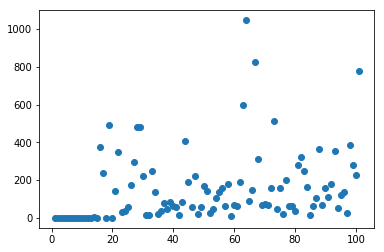

SystemExit: 

In [65]:
max_episodes = 100
fbAgentQLearning = FlappyBirdAgentQLearning()
fbEnvQ = FlappyBirdEnviornment(fbAgentQLearning)

if __name__ == '__main__':        
    fbEnvQ.simulate(max_episodes) 
   